In [1]:
import collections
from lung import volume_from_pressure, pressure_from_volume
import pandas as pd, numpy as np, matplotlib.pyplot as plt

pd.set_option('precision', 4)

"""
							In men 	In women
				Vital capacity 	4.8 	3.1 	IRV + TV + ERV
		Inspiratory capacity 	3.8 	2.4 	IRV + TV
Functional residual capacity 	2.4 	1.8 	ERV + RV
		Total lung capacity 	6.0 	4.2 	IRV + TV + ERV + RV 
"""
Patient_log = collections.namedtuple(
    'Patient_log', 
    ['time', 'pressure_mouth', 'pressure_alveolus', 'pressure_intrapleural', 'lung_volume', 'flow'])

class Patient:
    def __init__(self, 
                 height = 175, #cm
                 weight = 70, #kg
                 sex = 'M', # M or other
                 pressure_mouth = 0, #cmH2O
                 r = 10 # cmh2o/l/s or cmh2o per ml/ms
                ):
        self.time = 0 # miliseconds
        self.height = height
        self.weight = weight
        self.sex = sex
        self.TLC = 6000 if sex == 'M' else 4200 # todo calculate on age, height weight
        self.pressure_mouth = pressure_mouth
        self.r = r
        self.pressure_alveolus = pressure_mouth # start at equlibrium
        v_percent = volume_from_pressure(self.pressure_alveolus, 'Total') #assuming no resp effort
        self.lung_volume = self.TLC * v_percent / 100
        self.pressure_intrapleural = pressure_from_volume(v_percent, 'Chest')
        self.flow = 0
        self.log = []
    
    def status(self):
        return Patient_log(self.time, self.pressure_mouth, self.pressure_alveolus, self.pressure_intrapleural, self.lung_volume, self.flow)
            
    def advance(self, advance_time = 200, pressure_mouth = 0):
        self.time = self.time + advance_time # miliseconds
        self.pressure_mouth = pressure_mouth
        gradient = pressure_mouth - self.pressure_alveolus 
        self.flow = gradient / self.r # l/second or ml/ms
        self.lung_volume += self.flow * advance_time
        v_percent = self.lung_volume * 100 / self.TLC
        self.pressure_alveolus = pressure_from_volume(v_percent, "Total")
        self.pressure_intrapleural = pressure_from_volume(v_percent, "Chest")
        status = self.status()
        self.log.append(status)
        return status
        
        
Ventilator_log = collections.namedtuple('Ventilator_log', ['time', 'phase', 'pressure', 'pressure_mouth'])
class Ventilator:
    def __init__(self, mode = "PCV", Pi = 15, PEEP = 5, rate = 10, IE=0.5):
        self.pressure = 0
        self.pressure_mouth = 0
        self.mode = mode
        self.Pi = Pi
        self.mode = mode
        self.PEEP = PEEP
        self.rate = rate
        self.IE = IE
        self.phase = "E"
        self.log = []
        self.time = 0 # miliseconds
    
    def target_pressure(self):
        return self.PEEP if self.phase == "E" else self.Pi
    
    def status(self):
        return Ventilator_log(self.time, self.phase, self.pressure, self.pressure_mouth)
    
    def advance(self, advance_time = 200, pressure_mouth = 0):
        self.time = self.time + advance_time # miliseconds
        self.pressure_mouth = pressure_mouth # cmH2O
        # set phase
        breath_length = 60000 / self.rate # milliseconds
        time_since_inspiration_began = self.time % breath_length
        inspiration_length = breath_length * self.IE / (self.IE + 1)
        new_phase = "I" if time_since_inspiration_began < inspiration_length else "E"
        if new_phase != self.phase:
            self.phase = new_phase
            self.pressure = self.target_pressure()
            self.pressure_mouth = self.pressure # assume perfect ventilator
        status = self.status()
        self.log.append(status)
        return status

In [2]:
def plots(pdf, title):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True) # , gridspec_kw={'hspace': 0}
    fig.suptitle(title)
    ax1.plot(pdf['time'] / 1000, pdf['flow'], 'tab:green')
    ax1.set(ylabel = 'Flow (l/s)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.plot(pdf['time'] / 1000, pdf['pressure_mouth'], 'tab:blue')
    ax2.set(ylabel = 'P (cmH2O)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.plot(pdf['time'] / 1000, pdf['lung_volume'], 'tab:orange')
    ax3.set(ylabel = 'Volume (ml)', xlabel = 'time (seconds)')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax1.label_outer()
    ax2.label_outer()
    plt.show()
    
def run(patient, ventilator, start_time = 0, end_time = 20000, time_resolution = 50):
    print('starting', patient.status())
    patient_status = patient.advance(advance_time = 0)
    print('vent starting', ventilator.status())
    for current_time in range(start_time, end_time, time_resolution): 
        ventilator_status = ventilator.advance(advance_time = time_resolution, pressure_mouth = patient_status.pressure_mouth)
        patient_status = patient.advance(advance_time = time_resolution, pressure_mouth = ventilator_status.pressure_mouth)
    df = pd.DataFrame.from_records(p.log, columns=Patient_log._fields)
    return df

starting Patient_log(time=0, pressure_mouth=5, pressure_alveolus=5, pressure_intrapleural=0.3066470973524457, lung_volume=3138.522432016598, flow=0)
vent starting Ventilator_log(time=0, phase='E', pressure=0, pressure_mouth=0)


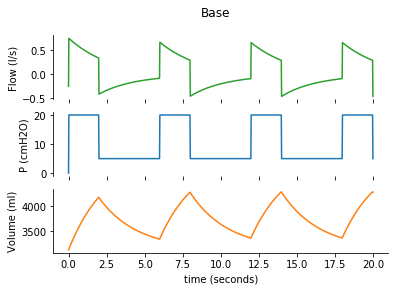

In [3]:
peep = 5
p = Patient(r=20, pressure_mouth=peep)
v = Ventilator(PEEP=peep, rate=10, IE=0.5, Pi = 20)
pdf = run(p, v, end_time = 20000, time_resolution=20)
plots(pdf, title='Base')

starting Patient_log(time=0, pressure_mouth=5, pressure_alveolus=5, pressure_intrapleural=0.3066470973524457, lung_volume=3138.522432016598, flow=0)
vent starting Ventilator_log(time=0, phase='E', pressure=0, pressure_mouth=0)


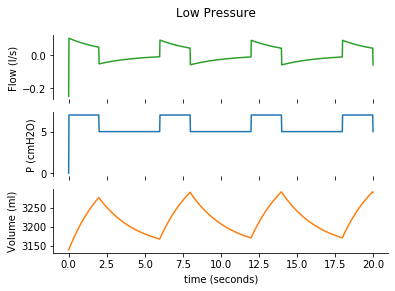

In [4]:
peep = 5
p = Patient(r=20, pressure_mouth=peep)
v = Ventilator(PEEP=peep, rate=10, IE=0.5, Pi = 7)
pdf = run(p, v, end_time = 20000, time_resolution=20)
plots(pdf, title='Low Pressure')

starting Patient_log(time=0, pressure_mouth=15, pressure_alveolus=15, pressure_intrapleural=5.494539462488488, lung_volume=4363.102082941603, flow=0)
vent starting Ventilator_log(time=0, phase='E', pressure=0, pressure_mouth=0)


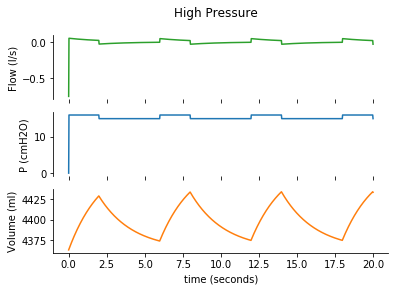

In [5]:
peep = 15
p = Patient(r=20, pressure_mouth=peep)
v = Ventilator(PEEP=peep, rate=10, IE=0.5, Pi = 16)
pdf = run(p, v, end_time = 20000, time_resolution=20)
plots(pdf, title='High Pressure')
